In [1]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import itertools
import scipy
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import LogNorm

from produce_dataset import *

In [2]:
ntuple_dir = '/ecoderemdvol/EleGun/EPGun-PU200/data/econ_ntuples/0002/'
root_dir = 'FloatingpointAutoEncoderEMDAEMSEttbarDummyHistomaxGenmatchGenclustersntuple'
#thresh_simenergy: False, read PU wafers too
df_econ = loadEconData(ntuple_dir,root_dir,'econ_data.csv',False)

df_gen = loadGenData(ntuple_dir,root_dir,'gen_data.csv')

In [3]:
df_nodes=df_econ[['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
       'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15', 
        'wafer_energy', 'tc_eta', 'tc_phi']]
df_nodes.reset_index(inplace=True)
df_nodes

,index,ECON_0,ECON_1,ECON_2,ECON_3,ECON_4,ECON_5,ECON_6,ECON_7,ECON_8,ECON_9,ECON_10,ECON_11,ECON_12,ECON_13,ECON_14,ECON_15,wafer_energy,tc_eta,tc_phi
0,0,0,128,0,128,128,0,128,128,192,64,64,64,192,128,64,128,0.0,-2.380200,2.320103
1,1,0,192,0,128,128,0,128,256,192,64,64,128,128,128,64,64,0.0,2.380200,2.320103
2,2,0,128,0,320,128,0,0,64,64,64,64,128,192,0,64,64,0.0,-2.386188,2.364755
3,3,0,256,128,128,128,0,128,256,0,64,0,192,64,128,128,64,0.0,-2.351344,2.769872
4,4,0,64,32,192,96,0,64,64,64,64,64,128,192,160,128,96,0.0,2.351344,2.769872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18152,18152,0,149,85,128,106,0,149,64,106,149,85,64,85,106,106,213,0.0,2.502979,2.501025
18153,18153,0,128,192,320,128,0,0,0,192,256,256,0,64,256,64,128,0.0,2.515603,2.327426
18154,18154,0,160,64,256,96,0,96,160,160,128,192,96,160,128,64,96,0.0,2.402795,2.174989
18155,18155,0,288,256,64,96,0,64,256,32,64,96,128,160,64,96,64,0.0,2.379769,2.002501


In [4]:
count = (df_econ['wafer_energy'] != 0).sum()
print(count)

1387


In [5]:
cols = ['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
       'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15']

#find sum of columns specified 
df_nodes['sum'] = df_nodes[cols].sum(axis=1)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [6]:
df_nodes.reset_index(drop=True,inplace=True)

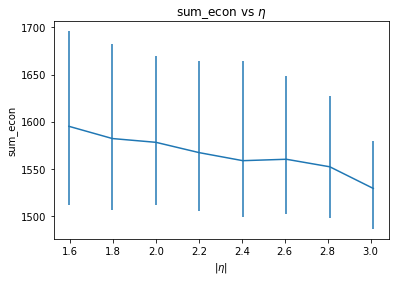

In [7]:
x=abs(df_nodes['tc_eta'])
y=df_nodes['sum']
        
nbins=8
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.ylabel('sum_econ')
plt.xlabel(r'$|\eta|}$')
plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie])
plt.title(r'sum_econ vs $\eta$');


Text(0.5, 1.0, 'sim energy vs $|\\eta|$')

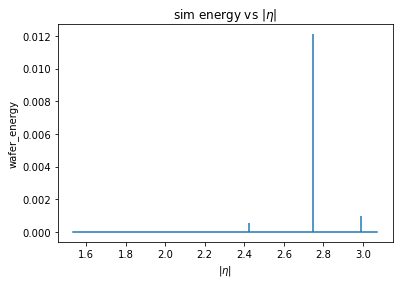

In [8]:
x=abs(df_nodes['tc_eta'])
y=df_nodes['wafer_energy']
        
nbins=20
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.ylabel('wafer_energy')
plt.xlabel(r'$|\eta|$')
plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie])
plt.title(r'sim energy vs $|\eta|$')


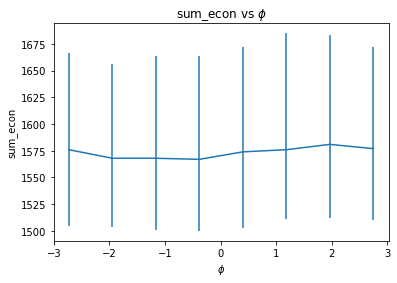

In [9]:
x=df_nodes['tc_phi']
y=df_nodes['sum']
        
nbins=8
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.ylabel('sum_econ')
plt.xlabel(r'$\phi$')
plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie])
plt.title(r'sum_econ vs $\phi$');

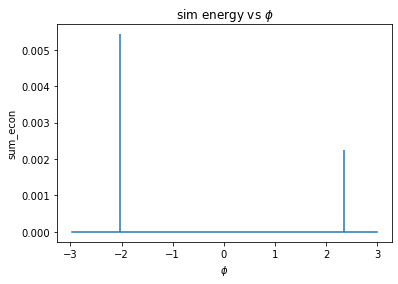

In [10]:
x=df_nodes['tc_phi']
y=df_nodes['wafer_energy']
        
nbins=20
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.ylabel('sum_econ')
plt.xlabel(r'$\phi$')
plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie])
plt.title(r'sim energy vs $\phi$');

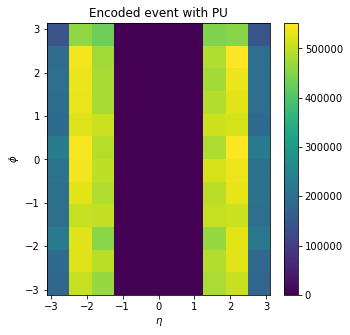

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
h = ax.hist2d(x=df_nodes['tc_eta'],y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['sum'])
fig.colorbar(h[3], ax=ax)
plt.xlabel(r'$\eta$');
plt.ylabel(r'$\phi$');
plt.title('Encoded event with PU');

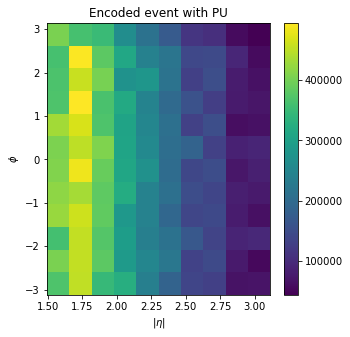

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
h = ax.hist2d(x=abs(df_nodes['tc_eta']),y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['sum'])
fig.colorbar(h[3], ax=ax)
plt.xlabel(r'$|\eta|$');
plt.ylabel(r'$\phi$');
plt.title('Encoded event with PU');

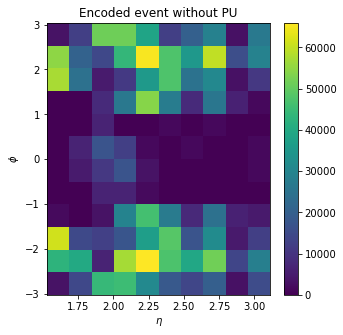

In [33]:
df_nodes_w_simenergy = df_nodes[df_nodes.wafer_energy>0]
fig, ax = plt.subplots(figsize=(5,5))
h = ax.hist2d(x=abs(df_nodes_w_simenergy['tc_eta']),y=df_nodes_w_simenergy['tc_phi'],bins=(10,12),weights=df_nodes_w_simenergy['sum'])
fig.colorbar(h[3], ax=ax)
plt.xlabel(r'$\eta$');
plt.ylabel(r'$\phi$');
plt.title('Encoded event without PU');

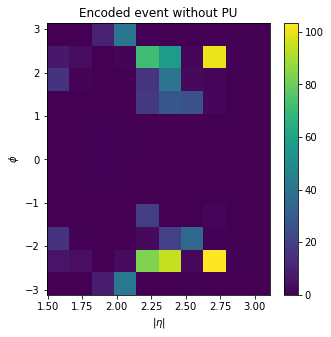

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
h = ax.hist2d(x=abs(df_nodes['tc_eta']),y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['wafer_energy'])
fig.colorbar(h[3], ax=ax)
plt.xlabel(r'$|\eta|$');
plt.ylabel(r'$\phi$');
plt.title('Encoded event without PU');